In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

In [2]:
import autosklearn.classification
import autosklearn.regression

/home/kyle/anaconda3/lib/python3.7/site-packages/pyparsing.py:3168: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [3]:
def ecdf(data):
    plt.plot(np.sort(data), np.linspace(0,1,len(data)))

## Data loading

In [4]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [5]:
train_o.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,12,2,2,4,1,3,1,11,15,1


In [6]:
def fillize(data):
    """Replace NaNs with zero, and adds indicator
    *only checks opened_position_qty"""
    nans = np.isnan(data["opened_position_qty"])
    return data.fillna(0).assign(nans=nans)

def deidize(data):
    """drop id column"""
    return data.drop("id", axis=1)

def relize(data):
    """replace bid[i] and ask[i] columns with
    bid[i]-bid[i-1] ans ask[i]-ask[i-1]"""
    rel = data.copy()
    for i in range(5,1,-1):
        rel[f"bid{i}"] = rel[f"bid{i-1}"] - rel[f"bid{i}"]
        rel[f"ask{i}"] -= rel[f"ask{i-1}"]

    rel["bid1"] = rel["last_price"] - rel["bid1"]
    rel["ask1"] -= rel["last_price"]
    return rel

import sklearn.preprocessing
def normall(datas):
    """standardize last_price, mid, and d_open_interest"""
    scaler_price = sklearn.preprocessing.StandardScaler()
    scaler_price.fit(datas[0][["last_price"]])
    scaler_interest = sklearn.preprocessing.StandardScaler()
    scaler_interest.fit(datas[0][["d_open_interest"]])

    normeds = []
    for data in datas:
        normed = data.copy()
        normed[["last_price","mid"]] = scaler_price.transform(normed[["last_price","mid"]])
        normed[["d_open_interest"]] = scaler_interest.transform(normed[["d_open_interest"]])
        normeds.append(normed)
    return normeds

def logize(data):
    cols = sum([
        ["opened_position_qty", "closed_position_qty", "transacted_qty"],
        [f"bid{i}" for i in range(2,6)],
        [f"bid{i}vol" for i in range(1,6)],
        [f"ask{i}" for i in range(2,6)],
        [f"ask{i}vol" for i in range(1,6)],
    ], [])
    logged = data.copy()
    logged.loc[:,cols] = np.log1p(logged.loc[:,cols])
    return logged

import sklearn.model_selection
def splitize(data):
    """make train and validation set"""
    return sklearn.model_selection.train_test_split(data.drop("y",axis=1), data["y"])

In [7]:
prepr = lambda data:logize(fillize(relize(deidize(data))))

ftrainX, ftrainY = prepr(train_o.drop("y",axis=1)), train_o["y"]
ftrainX, ftestX = normall([ftrainX, prepr(test_o)])

trainX, valX, trainY, valY = splitize(train_o)
trainX, valX, testX = normall([prepr(trainX), prepr(valX), prepr(test_o)])

In [8]:
trainX.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,nans
85996,-1.004329,-1.000663,1.098612,0.693147,1.386294,0.459241,-0.2,0.182322,0.182322,0.182322,...,2.302585,1.098612,1.609438,1.945910,1.386294,2.944439,0.693147,1.386294,1.609438,False
489689,0.704050,0.706494,1.098612,1.386294,1.791759,0.034181,0.0,0.182322,0.182322,0.182322,...,2.079442,2.302585,2.484907,2.079442,1.098612,1.791759,1.609438,1.609438,0.693147,False
13524,-1.483360,-1.487026,0.000000,0.000000,0.000000,0.034181,0.4,0.336472,0.182322,0.182322,...,0.693147,1.386294,1.791759,1.386294,0.693147,1.098612,1.098612,1.098612,2.079442,True
187394,-0.725710,-0.722044,0.000000,0.000000,0.000000,0.034181,-0.2,0.182322,0.182322,0.182322,...,1.386294,3.295837,2.772589,1.609438,1.609438,0.693147,2.197225,1.791759,2.302585,True
308203,0.664945,0.671055,1.386294,1.098612,1.791759,0.459241,-0.4,0.336472,0.182322,0.182322,...,2.708050,1.098612,1.098612,1.098612,2.079442,1.609438,1.609438,3.433987,1.791759,False


## Ridge

0.6576363201319897

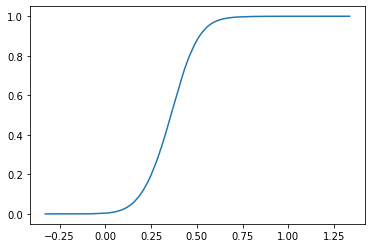

In [9]:
import sklearn.linear_model

ridge = sklearn.linear_model.Ridge(alpha=1)
ridge.fit(trainX, trainY)
p = ridge.predict(valX)
ecdf(p)
sklearn.metrics.roc_auc_score(valY, p)

In [10]:
import sklearn.model_selection

params = {
    "alpha": list(range(240,450,20))
}
gs = sklearn.model_selection.GridSearchCV(
    sklearn.linear_model.Ridge(), params, scoring="roc_auc"
)
gs.fit(trainX, trainY)

/home/kyle/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [240, 260, 280, 300, 320, 340, 360, 380, 400,
                                   420, 440]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

0.6578154602447002

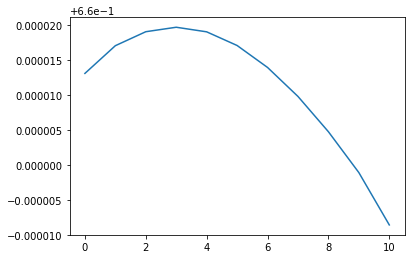

In [11]:
plt.plot(gs.cv_results_["mean_test_score"])
p = gs.predict(valX)
sklearn.metrics.roc_auc_score(valY, p)

## Predict

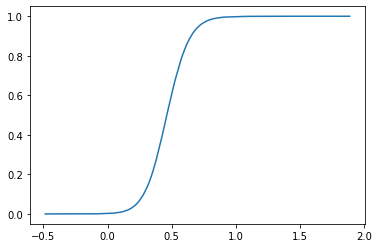

In [12]:
# fit on all data and predict
ridge = sklearn.linear_model.Ridge(alpha=200)
ridge.fit(ftrainX, ftrainY)
p = ridge.predict(ftestX)
ecdf(p)

0.17023695945739747
1.4442105066776276


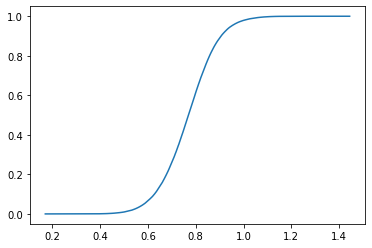

In [13]:
test_predicted = cls2.predict(testX.values)
ecdf(test_predicted)
print(min(test_predicted))
print(max(test_predicted))

0.11787544729128416
1.0


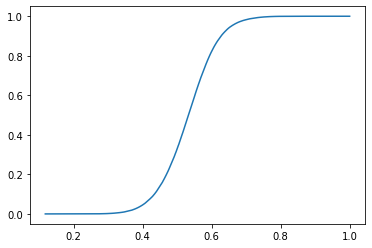

In [14]:
# oops, the max is above 1. let's scale by a constant
test_predicted /= max(test_predicted)
ecdf(test_predicted)
print(min(test_predicted))
print(max(test_predicted))
out = pd.DataFrame({"id":test_o.iloc[:, 0], "Predicted":test_predicted})
with open("test_predicted_2.csv", "w") as f:
    f.write(out.to_csv(index=False))

In [21]:
predicted = cls.predict(testX.values)

In [31]:
predicted_train = cls.predict(trainX.values)

In [43]:
predicted_train = np.array(predicted_train)

In [58]:
sklearn.metrics.roc_auc_score(trainY.values, predicted_train)

0.6086780317942908

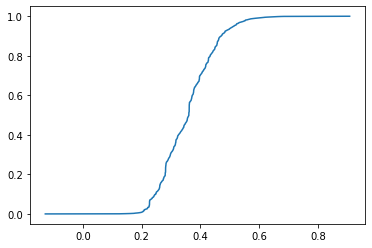

In [59]:
ecdf(predicted_train)

In [60]:
min(predicted_train)

-0.12769290804862976

In [63]:
scaled_predicted_train = predicted_train - min(predicted_train)

In [65]:
sklearn.metrics.roc_auc_score(trainY.values, scaled_predicted_train)

# interesting... same loss.

0.6086780317942908

In [66]:
test_predicted = cls.predict(testX.values)

In [67]:
test_predicted[0]

0.5748881101608276

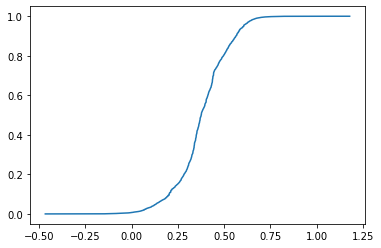

In [69]:
ecdf(test_predicted)

# Yeah, let's just additively rescale it.

In [72]:
test_predicted = test_predicted - min(test_predicted)
print(min(test_predicted))

# All good now.

0.0


In [73]:
out = pd.DataFrame({"id":test_o.iloc[:, 0], "Predicted":test_predicted})
with open("test_predicted_1.csv", "w") as f:
    f.write(out.to_csv(index=False))

## model time

In [14]:
cls = autosklearn.regression.AutoSklearnRegressor(
                                                  time_left_for_this_task=30*60,
                                                  ml_memory_limit=6144, n_jobs=4,
                                                  # tmp_folder="/media/kyle/sata",
                                                  output_folder="/media/kyle/sata/output")
cls.fit(trainX.values, trainY.values)

[WARNING] [2020-02-13 05:27:39,534:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:27:39,583:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:27:39,871:AutoMLSMBO(4282876139)::3e6e11a0307f1a5151d43d55e3125800] Could not find meta-data directory /home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2020-02-13 05:27:41,588:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:27:43,594:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:27:45,597:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:27:47,601:En

[WARNING] [2020-02-13 05:29:27,865:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:29:29,870:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:29:31,875:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:29:33,880:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:29:35,887:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:29:37,892:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:29:39,897:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than

[WARNING] [2020-02-13 05:31:20,160:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:31:22,165:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:31:24,169:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:31:26,174:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:31:28,180:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:31:30,185:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:31:32,189:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than

[WARNING] [2020-02-13 05:33:12,438:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:33:14,443:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:33:16,448:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:33:18,453:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:33:20,457:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:33:22,461:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 05:33:24,467:EnsembleBuilder(4282876139):3e6e11a0307f1a5151d43d55e3125800] No models better than

AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=6144, n_jobs=4,
                     output_folder='/media/kyle/sata/output',
                     per_run_time_limit=360, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task=1800, tmp_folder=None)

In [8]:
cls2 = autosklearn.classification.AutoSklearnClassifier(
                                                  time_left_for_this_task=45*60,
                                                  ml_memory_limit=90006144, n_jobs=4,
                                                  # tmp_folder="/media/kyle/sata",
                                                  output_folder="/media/kyle/sata/output")
cls2.fit(trainX.values, trainY.values)

[WARNING] [2020-02-13 06:51:23,039:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:51:23,084:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:51:25,098:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:51:27,111:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:51:29,130:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:51:31,151:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:51:33,167:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than

[WARNING] [2020-02-13 06:53:13,917:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:53:15,923:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:53:17,931:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:53:19,941:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:53:21,963:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:53:23,970:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:53:25,979:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than

[WARNING] [2020-02-13 06:55:06,725:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:55:08,735:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 06:55:10,742:EnsembleBuilder(4282876139):f2d316c82afdd2cbae8ed9ca3039af74] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 07:14:22,971:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-02-13 07:14:22,971:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py",

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 197, in main
    selected_models = self.get_n_best_preds()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 382, in get_n_best_preds
    dummy_score[1])
  File "/home/kyle/anaconda3/lib/py

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'No new model predictions selected -- skip ensemble building -- current performance: %f'
Arguments: (0.32785185690413665,)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line

Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 197.60571336746216)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    sel

  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  Fil

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielde

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/l

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/a

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 189.5818498134613)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 181.2464475631714)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 173.21557760238647)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 165.08172821998596)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 157.11372470855713)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 148.9476728439331)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 140.96726989746094)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 133.05922746658325)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 124.9924144744873)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 117.11772298812866)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(se

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 109.3896996974945)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 101.63052201271057)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 93.6336944103241)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 85.81368851661682)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 395, in fit
    p.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = proc

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_aut

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anacon

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, 

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 193, in main
    if not self.read_ensemble_preds():
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 241, in read_ensemble_preds
    self.logger.debug("Read ensemble data set predictions")
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Read ensemble data set predictions'
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 357, in read_ensemble_preds
    np.sum([pred["loaded"] > 0 for pred in self.read_preds.values()])
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Done reading %d new prediction files. Loaded %d predictions in total.'
Arguments: (0, 57)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ky

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-package

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py",

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run


  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 193, in main
    if not self.read_ensemble_preds():
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 241, in read_ensemble_preds
    self.logger.debug("Read ensemble data set predictions")
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.deb

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 193, in main
    if not self.read_ensemble_preds():
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 357, in read_ensemble_preds
    np.sum([pred["loaded"] > 0 for pred in self.read_preds.values()])
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Done reading %d new prediction files. Loaded %d predictions in total.'
Arguments: (0, 57)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_mai

Message: 'Use 0.643140 as dummy score'
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home

  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  Fil

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interac

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-i

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,


  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anacon

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/pytho

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 193, in main
    if not self.read_ensemble_preds():
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 357, in read_ensemble_preds
    np.sum([pred["loaded"] > 0 for pred in self.read_preds.values()])
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Done reading %d new prediction files. Loaded %d predictions in total.'
Arguments: (0, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 197, in main
    selected_models = self.get_n_best_preds()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 382, in get_n_best_preds
    dummy_score[1])
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Use 0.643140 as dummy score'
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in

--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/a

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-i

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_aut

  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multi

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/pytho

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, 

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 197, in main
    selected_models = self.get_n_best_preds()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 382, in get_n_best_preds
    dummy_score[1])
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'U

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'No new model predictions selected -- skip ensemble building -- current performance: %f'
Arguments: (0.32785185690413665,)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run

Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", l

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,


  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run


  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 197, in main
    selected_models = self.get_n_best_preds()
  File "/home/kyle/anaconda3/lib/python3.7/site-packag

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'No new model predictions selected -- skip ensemble building -- current performance: %f'
Arguments: (0.32785185690413665,)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/pyt

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 48.14639091491699)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line

OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 40.6994366645813)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 33.129404067993164)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 25.59412431716919)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/smbo.py", line 504, in run_smbo
    smac.optimize()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/smac/facade/smac_facade.py", line 402, in optimize
    self.solver.stats.save()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/smac/stats/stats.py", line 77, in save
    json.dump(data, fh)
OSError: [Errno 28] No space left on device
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28]

Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 23.22344207763672)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self

  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  Fil

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielde

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/l

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/a

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", lin

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_o

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 195, in __call__
    subproc.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.p

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 216, in main
    ensemble = self.fit_ensemble(selected_keys=selected_models)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 544, in fit_ensemble
    self.validation_performance_,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 189, in main
    self.time_limit - used_time,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 16.10967183113098)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line

  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in r

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/ho

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/h

--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/p

--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/p

--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/p

--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaco

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/p

Message: 'Starting iteration %d, time left: %f'
Arguments: (28, 11.383878946304321)
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    sel

  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  Fil

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielde

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 382, in get_n_best_preds
    dummy_score[1])
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/util/logging_.py", line 66, in debug
    self.logger.debug(msg, *args, **kwargs)
Message: 'Use 0.643140 as dummy score'
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch

OSError: [Errno 28] No space left on device

--- Logging error ---
Traceback (most recent call last):
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/kyle/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kyle/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/p

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.

  File "/home/kyle/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kyle/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/a

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-i

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_aut

  File "<ipython-input-8-b904ddd0bc02>", line 6, in <module>
    cls2.fit(trainX.values, trainY.values)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multi

  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/automl.py", line 426, in _fit
    self._proc_ensemble.start()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/pytho

  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/kyle/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 156, in run
    safe_ensemble_script()
  File "/home/kyle/anaconda3/lib/python3.7/site-packages/pynisher/limit_function_call.

In [10]:
clsf = autosklearn.regression.AutoSklearnRegressor(ml_memory_limit=6144, time_left_for_this_task=30)
clsf.fit(trainX.values, trainY.values)

[WARNING] [2020-02-13 02:43:29,981:EnsembleBuilder(1):723e8ebb4a8797f62fa25731c93780cd] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 02:43:29,997:EnsembleBuilder(1):723e8ebb4a8797f62fa25731c93780cd] No models better than random - using Dummy Score!
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (29.240119)
[WARNING] [2020-02-13 02:43:30,052:AutoMLSMBO(1)::723e8ebb4a8797f62fa25731c93780cd] Could not find meta-data directory /home/kyle/anaconda3/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2020-02-13 02:43:32,002:EnsembleBuilder(1):723e8ebb4a8797f62fa25731c93780cd] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 02:43:34,010:EnsembleBuilder(1):723e8ebb4a8797f62fa25731c93780cd] No models better than random - using Dummy Score!
[WARNING] [2020-02-13 02:43:36,017:EnsembleBuilder(1):723e8ebb4a8797f62fa25731c93780cd] N

AutoSklearnRegressor(delete_output_folder_after_terminate=True,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=6144, n_jobs=None, output_folder=None,
                     per_run_time_limit=360, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     shared_mode=False, smac_scenario_args=None,
                     time_left_for_this_task=30, tmp_folder=None)

In [ ]:
cls